# Imbalance task - SMOTE

#### Author: Krzysztof Baran

## Shared Code

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from sklearn.neighbors import NearestNeighbors
import re
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

In [2]:
# Load the data inside pandas Dataframe
import os

train_data_path = os.path.join(os.getcwd(), "data", "train_data.csv")

train_data_df = pd.read_csv(train_data_path)
train_data_df.set_index('Id', inplace=True)

In [3]:
from datetime import date # datetime works too
from currency_converter import CurrencyConverter
c = CurrencyConverter()

def conv(row, data_conv=date(2023, 1, 2)):
    return c.convert(row['amount'], row['currencycode'], 'EUR', date=data_conv)

In [4]:
def country_equal_feature_eng(df):
    # Check if the shopper's country of origin is the same as the issuer country
    df['countries_equal'] = (df['shoppercountrycode'] == df['issuercountrycode'])
    df.loc[df['countries_equal'] == False, 'countries_equal'] = 0
    df.loc[df['countries_equal'] == True, 'countries_equal'] = 1

    return df


class CustomDataTransformer(BaseEstimator, TransformerMixin):

    def __init__(
        self, currency_conv_func,
        feature_engineering_func=country_equal_feature_eng,
        card_enc=LabelEncoder(),
        ip_enc=LabelEncoder(),
        country_code_enc=LabelEncoder(),
        tx_variant_code_enc=LabelEncoder(),
        currency_code_enc=LabelEncoder(),
        shopper_interaction_enc=LabelEncoder(),
        account_code_enc=LabelEncoder(),
        card_verif_code_supplied=LabelEncoder(),
        mail_id_enc=LabelEncoder(),
        bin_encoder=LabelEncoder(),
        scaler=StandardScaler(),

        drop_private_columns=False,
        columns_to_scale=None,
        one_hot_columns=None

    ):
        '''

        :param currency_conv_func: currency conversion function
        :param feature_engineering_func: feature engineering function
        :param card_enc: card encoder
        :param ip_enc: ip encoder
        :param country_code_enc:  country code encoder
        :param tx_variant_code_enc: tx variant code encoder
        :param currency_code_enc:  currency code encoder
        :param shopper_interaction_enc:  shopper interaction encoder
        :param account_code_enc: account code encoder
        :param card_verif_code_supplied: card verification code supplied encoder
        :param mail_id_enc: mail id encoder
        :param scaler: scaler used
        :param drop_private_columns: drop columns that might be considered sensitive data (e.g. mail_id)
        :param columns_to_scale: columns that will be scaled using the scaler
        :param one_hot_columns: columns that will be one-hot encoded
        '''
        self.card_enc = card_enc
        self.ip_enc = ip_enc
        self.country_code_enc = country_code_enc
        self.tx_variant_code_enc = tx_variant_code_enc
        self.currency_code_enc = currency_code_enc
        self.shopper_interaction_enc = shopper_interaction_enc
        self.account_code_enc = account_code_enc
        self.bin_enc = bin_encoder
        self.card_verif_code_supplied = card_verif_code_supplied
        self.mail_id_enc = mail_id_enc

        self.currency_conv_func = currency_conv_func
        self.feature_eng_func = feature_engineering_func

        self.country_codes = None
        self.cleaned_data = None

        self.scaler = scaler
        if columns_to_scale is None:
            self.columns_to_scale = []
        else:
            self.columns_to_scale = columns_to_scale
        if one_hot_columns is None:
            self.one_hot_columns = []
        else:
            self.one_hot_columns = one_hot_columns

        self.drop_private_columns = drop_private_columns

    def _clean_data(self, df):
        # Cleaning up data inconsisstencies
        df.loc[df['cardverificationcodesupplied'].isna(), 'cardverificationcodesupplied'] = False
        # df.loc[df['mail_id'].str.contains('na', case=False), 'mail_id'] = 'email99999'
        df.loc[df['cvcresponsecode'] > 2, 'cvcresponsecode'] = 3

        df.loc[df['issuercountrycode'].isna(), 'issuercountrycode'] = '--'
        df.loc[df['shoppercountrycode'].isna(), 'shoppercountrycode'] = '--'
        unique_issuer_cc = df['issuercountrycode'].unique()
        unique_shopper_cc = df['shoppercountrycode'].unique()
        both = np.append(unique_issuer_cc, unique_shopper_cc)
        df_countrycodes = pd.DataFrame(both)
        unique_country_codes = df_countrycodes[0].unique()
        self.country_codes = unique_country_codes

        df['amount_eur'] = df.apply(lambda x: self.currency_conv_func(x), axis=1)
        df.drop("amount", axis=1, inplace=True)
        df['accountcode'] = df['accountcode'].apply(lambda x: re.sub('Account','',x))
        df.loc[(df['accountcode'] == 'UK'),'accountcode'] = 'GB'
        df.loc[(df['accountcode'] == 'Mexico'),'accountcode'] = 'MX'
        df.loc[(df['accountcode'] == 'Sweden'),'accountcode'] = 'SE'
        df.loc[(df['accountcode'] == 'APAC'),'accountcode'] = 'APAC'


        return df

    def fit(self, X, y=None):
        df = X.copy(deep=True)
        df = self._clean_data(df)

        # 1.Card ID
        self.card_enc.fit(df['card_id'])


        # 2.IP ID
        self.ip_enc.fit(df['ip_id'])

        # 3. Country code
        self.country_code_enc.fit(self.country_codes)

        # 4. TX variant code
        self.tx_variant_code_enc.fit(df['txvariantcode'])

        # 5. Currency code
        self.currency_code_enc.fit(df['currencycode'])

        # 6. Shopper Interaction
        self.shopper_interaction_enc.fit(df['shopperinteraction'])

        # 7. Account code
        self.account_code_enc.fit(df['accountcode'])
        # df['accountcode'] = self.account_code_enc.transform(df.accountcode)

        # 8. Card Verification Code Supplied
        self.card_verif_code_supplied.fit(df['cardverificationcodesupplied'])
        # df['cardverificationcodesupplied'] = self.card_verif_code_supplied.transform(
        #     df.cardverificationcodesupplied
        # )

        # 9. Email ID
        self.mail_id_enc.fit(df['mail_id'])

        # 10. Bin
        self.bin_enc.fit(df['bin'])
        # df['mail_id'] = self.mail_id_enc.transform(df.mail_id)
        # df.drop("mail_id", axis=1, inplace=True)
        #
        # # Fit the scaler
        # if self.scaler is not None:
        #     self.scaler.fit(df)

        return self

    def transform(self, X):
        df = X.copy(deep=True)
        df = self._clean_data(df)

        # Feature Engineering
        if self.feature_eng_func is not None:
            df = self.feature_eng_func(df)

        # 1.Card ID
        if self.drop_private_columns:
            df.drop("card_id", axis=1, inplace=True)
        else:
            df['card_id'] = self.card_enc.transform(df.card_id)

        # 2.IP ID
        # df['ip_id'] = self.ip_enc.transform(df.ip_id)
        if self.drop_private_columns:
            df.drop("ip_id", axis=1, inplace=True)
        else:
            df['ip_id'] = self.ip_enc.transform(df.ip_id)
        # 3. Country code
        if 'issuercountrycode' not in self.one_hot_columns:
            df['issuercountrycode'] = self.country_code_enc.transform(df.issuercountrycode)
        if 'shoppercountrycode' not in self.one_hot_columns:
            df['shoppercountrycode'] = self.country_code_enc.transform(df.shoppercountrycode)

        # 4. TX variant code
        if 'txvariantcode' not in self.one_hot_columns:
            df['txvariantcode'] = self.tx_variant_code_enc.transform(df.txvariantcode)

        # 5. Currency code
        if 'currencycode' not in self.one_hot_columns:
            df['currencycode'] = self.currency_code_enc.transform(df.currencycode)

        # 6. Shopper Interaction
        if 'shopperinteraction' not in self.one_hot_columns:
            df['shopperinteraction'] = self.shopper_interaction_enc.transform(
                df.shopperinteraction
            )

        # 7. Account code
        if 'accountcode' not in self.one_hot_columns:
            df['accountcode'] = self.account_code_enc.transform(df.accountcode)

        # 8. Card Verification Code Supplied
        if 'cardverificationcodesupplied' not in self.one_hot_columns:
            df['cardverificationcodesupplied'] = self.card_verif_code_supplied.transform(df['cardverificationcodesupplied'])

        # 9. Email ID
        if self.drop_private_columns:
            df.drop("mail_id", axis=1, inplace=True)
        else:
            df['mail_id'] = self.mail_id_enc.transform(df.mail_id)

        # 10. Bin
        if self.drop_private_columns:
            df.drop("bin", axis=1, inplace=True)
        else:
            df['bin'] = self.bin_enc.transform(df.bin)
        # df.drop("bin", axis=1, inplace=True)

        # Scale the data
        if self.scaler is not None and len(self.columns_to_scale) > 0:
            # Columns to scale
            scale_columns = np.array(df[self.columns_to_scale])
            if len(scale_columns.shape) == 1:
                scale_columns = scale_columns.reshape(-1, 1)
                df[self.columns_to_scale] = self.scaler.fit_transform(scale_columns).reshape(-1)
            df[self.columns_to_scale] = self.scaler.fit_transform(scale_columns)

        if len(self.one_hot_columns) > 0:
            df = self.one_hot_encode(df)
        return df

    def one_hot_encode(self, df):
        # One hot encode the selected columns
        cols_to_encode = df[self.one_hot_columns]
        encoder = OneHotEncoder(sparse=False)
        encoded_cols = encoder.fit_transform(cols_to_encode)
        encoded_cols_df = pd.DataFrame(
            encoded_cols, columns=encoder.get_feature_names(self.one_hot_columns), index=df.index
        )
        df.drop(self.one_hot_columns, axis=1, inplace=True)
        df = pd.concat([df, encoded_cols_df], axis=1)

        return df


In [7]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Regular pipeline
pipeline = Pipeline([
    ('custom_transform', CustomDataTransformer(conv, feature_engineering_func=country_equal_feature_eng,
                                               columns_to_scale=['issuercountrycode', 'txvariantcode', 'bin', 'currencycode',
       'shoppercountrycode', 'shopperinteraction',
       'cardverificationcodesupplied', 'cvcresponsecode', 'accountcode',
       'label', 'amount_eur', 'countries_equal', 'card_id', 'ip_id', 'mail_id'], scaler = MinMaxScaler())),  # apply the custom function
])

# fit the pipeline to your data and transform it
transformed_data_df = pipeline.fit_transform(train_data_df)
transformed_data_df

,issuercountrycode,txvariantcode,bin,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label,amount_eur,countries_equal
Id,,,,,,,,,,,,,,,
1,0.340136,0.166667,0.904139,0.25,0.342466,0.5,1.0,0.333333,0.333333,0.104575,0.074526,0.613989,0.0,0.014962,1.0
2,0.340136,0.250000,0.979730,0.25,0.342466,0.5,1.0,0.333333,0.333333,0.679079,0.638575,0.173973,0.0,0.011265,1.0
3,0.340136,0.166667,0.855574,0.25,0.342466,0.5,1.0,0.333333,0.333333,0.497187,0.518869,0.720433,0.0,0.012938,1.0
4,0.340136,0.666667,0.422297,0.25,0.342466,0.0,0.0,0.000000,0.333333,0.586427,0.874296,0.085653,0.0,0.051249,1.0
6,0.340136,0.666667,0.472551,0.25,0.342466,0.5,1.0,0.333333,0.333333,0.720216,0.335182,0.441547,0.0,0.016953,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237030,0.340136,0.166667,0.703547,0.25,0.342466,0.5,1.0,0.333333,0.333333,0.576624,0.664919,0.930229,0.0,0.036376,1.0
237031,0.340136,0.666667,0.472973,0.25,0.342466,0.5,1.0,0.333333,0.333333,0.905891,0.971891,0.487005,0.0,0.006246,1.0
237032,0.340136,0.666667,0.473818,0.25,0.342466,0.5,1.0,0.333333,0.333333,0.418607,0.858361,0.026537,0.0,0.010596,1.0


In [8]:
def train_classifier_and_plot(classifier, data_quad, cv_func=None):
    X_train_data, X_test_data, y_train_data, y_test_data = data_quad
    if cv_func is None:
        classifier.fit(X_train_data, y_train_data)
    else:
        classifier = cv_func(X, y, classifier,
                             scoring='accuracy',
                             k=10
        )

    y_predictions = classifier.predict(X_test_data)
    y_predictions_proba = classifier.predict_proba(X_test_data)[:, 1]

    print(classification_report(y_test_data, y_predictions))
    print(f"Accuracy: {accuracy_score(y_test_data, y_predictions) * 100:.2f}")

    fpr, tpr, _ = roc_curve(y_test_data, y_predictions_proba)
    roc_auc = auc(fpr, tpr)

    ConfusionMatrixDisplay.from_predictions(y_test_data, y_predictions)
    plt.show()
    return fpr, tpr, roc_auc, classifier


def plot_roc_curves(plot_title, *plot_tuples):
    plt.clf()
    for plot_tuple in plot_tuples:
        plt.plot(plot_tuple[0], plot_tuple[1], label=plot_tuple[2])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(plot_title)
    plt.legend()
    plt.show()

## Implementation

In [9]:
def nearest_neighbours(data_in, k=5):
    kNN = NearestNeighbors(n_neighbors=k, metric='euclidean', algorithm='auto').fit(data_in)
    indices = kNN.kneighbors(data_in, return_distance=False)
    return indices

example_np = [[0.0,1.0,3.2], [3.4,0.2,1.1], [0.6,1.0,1.0]]

ind_matrix = nearest_neighbours(example_np, k=3)
ind_matrix

array([[0, 2, 1],
       [1, 2, 0],
       [2, 0, 1]])

## SMOTE implementation

In [10]:
import random

def smote_custom(train_data_df, k=5, sample_num=100, random_state=None):
    kNN_matrix = nearest_neighbours(train_data_df, k=k)
    rng = random.Random() if random_state is None else random.Random(random_state)

    X = train_data_df.to_numpy()

    X_new = []

    for i, x_sample in enumerate(X):
        for _ in range(sample_num):
            rand_nn = rng.randrange(1, k)

            nn_point = X[kNN_matrix[i][rand_nn]]

            diff = nn_point - x_sample
            gap = rng.uniform(0, 1)

            new_data_point = x_sample + gap * diff
            X_new.append(new_data_point)
    X_new = np.array(X_new)
    genereated_samples_df = pd.DataFrame(X_new, columns=train_data_df.columns)
    return genereated_samples_df

## Data Division

In [11]:
import time
from sklearn.model_selection import train_test_split

X = transformed_data_df.drop(['label'], axis=1)
y = transformed_data_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_fraud = X_train.loc[y_train == 1]

start = time.time()
X_fraud_smote = smote_custom(X_train_fraud.copy(), sample_num=750, random_state=0)
smote_time = time.time() - start

print(f'SMOTE time: {smote_time:.2f}s')

X_fraud_smote.head()

SMOTE time: 0.74s


,issuercountrycode,txvariantcode,bin,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,amount_eur,countries_equal
0,0.068027,0.479830,0.305648,0.0,0.068493,0.5,1.0,0.0,0.0,0.734606,0.083126,0.645290,0.136993,1.0
1,0.068027,0.420040,0.171425,0.0,0.068493,0.5,1.0,0.0,0.0,0.415971,0.186109,0.820942,0.039413,1.0
2,0.068027,0.450411,0.239605,0.0,0.068493,0.5,1.0,0.0,0.0,0.577826,0.133797,0.731717,0.088980,1.0
3,0.068027,0.658617,0.129521,0.0,0.068493,0.5,1.0,0.0,0.0,0.771628,0.490186,0.968358,0.080524,1.0
4,0.068027,0.562512,0.143157,0.0,0.068493,0.5,1.0,0.0,0.0,0.623217,0.371712,0.913740,0.062008,1.0


In [12]:
from sklearn.utils import shuffle

before_smote_valid = len(y_train[y_train == 0])
before_smote_fraud = len(y_train[y_train == 1])

X_train = pd.concat([X_train, X_fraud_smote])
y_train = pd.concat([
    y_train,
    pd.Series(1, index=range(len(X_fraud_smote)))
])

X_train, y_train = shuffle(X_train, y_train, random_state=0)

after_smote_valid = len(y_train[y_train == 0])
after_smote_fraud = len(y_train[y_train == 1])

results_smote_matrix = pd.DataFrame([
    ["before", before_smote_valid, before_smote_fraud],
    ["after", after_smote_valid, after_smote_fraud]],
    columns=["SMOTE", "valid", "fraud"])
results_smote_matrix.set_index('SMOTE', inplace=True)
results_smote_matrix

,valid,fraud
SMOTE,,
before,151490,212
after,151490,159212


In [13]:
train_test_pairs = (X_train, X_test, y_train, y_test)
# Get the number of nans
print(f"Number of NaNs: {X_train.isna().sum()}")
X_train.head()

Number of NaNs: issuercountrycode               0
txvariantcode                   0
bin                             0
currencycode                    0
shoppercountrycode              0
shopperinteraction              0
cardverificationcodesupplied    0
cvcresponsecode                 0
accountcode                     0
mail_id                         0
ip_id                           0
card_id                         0
amount_eur                      0
countries_equal                 0
dtype: int64


,issuercountrycode,txvariantcode,bin,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,amount_eur,countries_equal
94095,0.340136,0.666667,0.565034,0.25,0.342466,0.5,0.0,0.333333,0.333333,0.509444,0.460309,0.741852,0.013540,1.0
108133,0.340136,0.666667,0.422297,0.25,0.342466,0.5,1.0,0.333333,0.333333,0.092124,0.334611,0.647297,0.010863,1.0
213999,0.340136,0.166667,0.856419,0.25,0.342466,0.5,1.0,0.333333,0.333333,0.853512,0.503819,0.125255,0.006263,1.0
153253,0.340136,0.166667,0.627534,0.25,0.342466,0.5,1.0,0.333333,0.333333,0.764096,0.522138,0.673607,0.036878,1.0
214483,0.340136,0.500000,0.068412,0.25,0.342466,0.5,0.0,0.333333,0.333333,0.205462,0.095645,0.209866,0.008254,1.0


## Logistic Regression

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

         0.0       1.00      0.88      0.94     37862
         1.0       0.01      0.89      0.02        64

    accuracy                           0.88     37926
   macro avg       0.51      0.89      0.48     37926
weighted avg       1.00      0.88      0.94     37926

Accuracy: 88.24


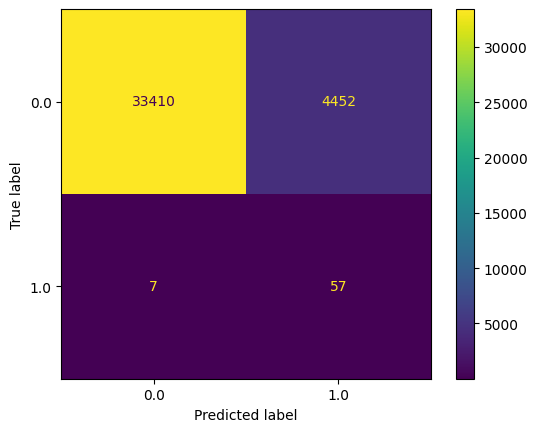

In [14]:
logreg_classifier = LogisticRegression(random_state=0, n_jobs=-1)
logreg_fpr, logreg_tpr, logreg_roc_auc, _ = train_classifier_and_plot(
    logreg_classifier, train_test_pairs
)

## Decision Tree

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97     37862
         1.0       0.02      0.66      0.04        64

    accuracy                           0.94     37926
   macro avg       0.51      0.80      0.50     37926
weighted avg       1.00      0.94      0.97     37926

Accuracy: 94.42


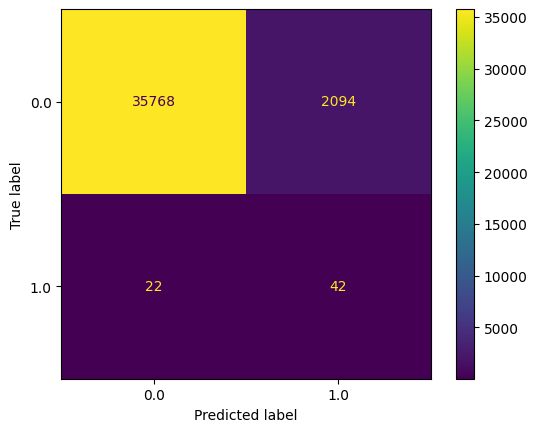

In [15]:
dtree_classifier = DecisionTreeClassifier(max_depth=10, random_state=0)
dtree_fpr, dtree_tpr, dtree_roc_auc, _ = train_classifier_and_plot(
    dtree_classifier, train_test_pairs
)

## Random Forest

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     37862
         1.0       0.12      0.12      0.12        64

    accuracy                           1.00     37926
   macro avg       0.56      0.56      0.56     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.70


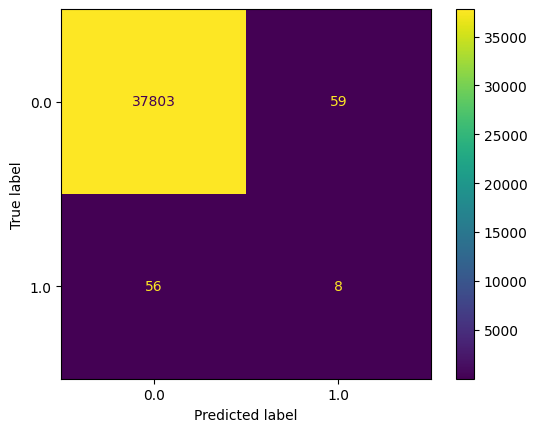

In [16]:
forest_classifier = RandomForestClassifier(random_state=0, n_jobs=-1)
forest_fpr, forest_tpr, forest_roc_auc, _ = train_classifier_and_plot(
    forest_classifier, train_test_pairs
)

## ROC curve for the SMOTED dataset

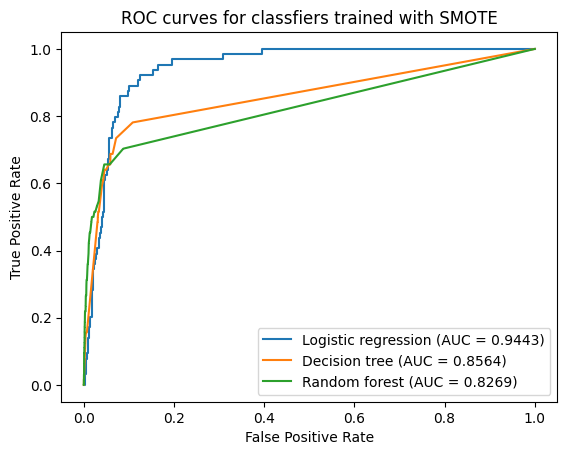

In [17]:
plot_roc_curves(
    "ROC curves for classfiers trained with SMOTE",
    (logreg_fpr, logreg_tpr, f"Logistic regression (AUC = {logreg_roc_auc:.4f})"),
    (dtree_fpr, dtree_tpr, f"Decision tree (AUC = {dtree_roc_auc:.4f})"),
    (forest_fpr, forest_tpr, f"Random forest (AUC = {forest_roc_auc:.4f})")
)

#### **Conclusion**

As we can see, generally the SMOTEing helped to to be more alert for fraudeulent transactions which increaced our recall compared to before without any previous.

However, SMOTEing has led to an increase in the False Positive Rate (FPR) and our percision which is not very desirable from the point of view of a bank customer as falsely flagging someone's transaction as fraudlent, as that would require an expensive manual intervention with an explanation from the bank. On top of that, it could harm the customer's trust.

As seen from our results, we can see that in this case Logistic Regression seems to perform best as it assumes a linear relationship between the features and the target variable which is the case in our Label Encoding method. However, due to a very low percision, it would not be recommended to use this model as that could cause a lot of manual reviews.

Although the results from these classifers are not ideal, we have shown that SMOTE helps to improve the performance for all tested classifiers and seems to be a good first step to deal with imbalanced data. However, because SMOTE introduces new data points, it may not be aware of hyperplane boundries and introduce some new points that can confuse the classifers. Therefore, an extra setp would be needed, e.g. using Tomek links to remove majority points too close to minority points.